In [ ]:
import pandas as pd
import seaborn as sns
import random
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers.experimental.preprocessing import Normalization
from keras.optimizers import Adam
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score,precision_score,f1_score,confusion_matrix
import keras.metrics
import matplotlib.pyplot as plt

In [ ]:
def load_split_data():
  df=pd.read_csv("/content/drive/MyDrive/dataset/magic04.csv")
  seed=0
  test_data=df.sample(frac=0.3,random_state=seed)
  train_data=df.drop(test_data.index)
  return train_data,test_data

In [ ]:
train_data

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
0,45.194199,26.435101,3.1055,0.2290,0.1235,11.295100,39.522202,22.867800,7.879700,116.305000
1,35.557800,7.630700,2.3608,0.5229,0.3159,-28.440901,-25.817101,7.996600,31.497999,181.839996
2,80.750298,30.581200,3.8613,0.1555,0.0832,-53.329201,77.732498,22.163401,5.239000,309.130005
3,30.370600,20.158800,2.5711,0.2926,0.1597,1.156700,-13.103400,17.462601,60.779499,263.980011
4,29.697901,0.000000,2.3284,0.6338,0.4014,0.000000,0.000000,-17.635500,9.010000,105.221001
...,...,...,...,...,...,...,...,...,...,...
9337,182.500305,76.556801,3.6872,0.1123,0.0666,192.267502,93.030197,-62.619202,82.169098,283.473114
9338,21.384600,10.917000,2.6161,0.5857,0.3934,15.261800,11.524500,2.876600,2.422900,106.825798
9339,28.945200,6.702000,2.2672,0.5351,0.2784,37.081600,13.185300,-2.963200,86.797501,247.455994
9340,75.445503,47.530499,3.4483,0.1417,0.0549,-9.356100,41.056198,-9.466200,30.298700,256.516602


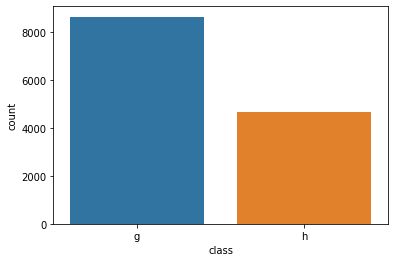

In [ ]:
train_data,test_data=load_split_data()
sns.countplot(x='class',data=train_data)

In [ ]:
train_data['class'].value_counts()

g    8643
h    4671
Name: class, dtype: int64

In [ ]:
def sample_together(n, X, y):
    rows = random.sample(np.arange(0,len(X.index)).tolist(),n)
    return X.iloc[rows,], y.iloc[rows,]
def undersample(train_data, under = 'h'):
    y=train_data.pop('class')
    X=train_data
    y_min = y[y == under]
    y_max = y[y != under]
    X_min = X.filter(y_min.index,axis = 0)
    X_max = X.filter(y_max.index,axis = 0)

    X_under, y_under = sample_together(len(y_min.index), X_max, y_max)
    
    X = pd.concat([X_under, X_min])
    y = pd.concat([y_under, y_min])
    y_train=np.array(y)
    y_train=y_train.reshape((y_train.shape[0],1))
    train_data=np.concatenate((X,y_train),axis=1)
    train_data=pd.DataFrame(train_data)
    train_data.columns=['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long','fM3Trans', 'fAlpha', 'fDist', 'class']
    return train_data

In [ ]:
train_data=undersample(train_data)

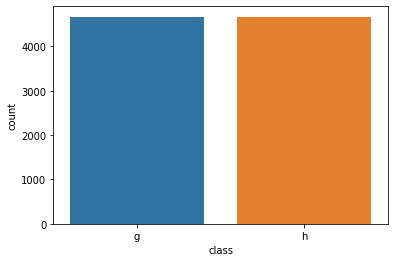

In [ ]:
sns.countplot(x='class',data=train_data)

In [ ]:
train_data['class'].value_counts()

g    4671
h    4671
Name: class, dtype: int64

In [ ]:
Y_train=train_data.pop('class')
Y_test=test_data.pop('class')

In [ ]:
def get_knns():
  scores_list=[]
  for i in range(1,25,2):
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(train_data,Y_train)
    scores=cross_val_score(knn,train_data,Y_train,cv=5)
    average_score=sum(scores)/len(scores)
    scores_list.append(average_score)
  return scores_list

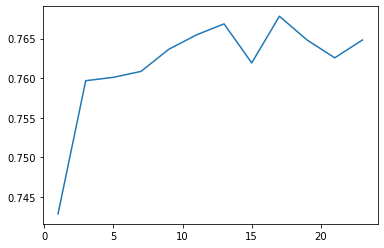

In [ ]:
scores_list=get_knns()
plt.plot(range(1,25,2),scores_list)

In [ ]:
def get_best_knn(scores_list):
  n=np.argmax(scores_list)
  knn_best=KNeighborsClassifier(n_neighbors=(2*n)+1)
  knn_best.fit(train_data,Y_train)
  return knn_best

In [ ]:
knn_best=get_best_knn(scores_list)

In [ ]:
Y_hat=knn_best.predict(test_data)
accuracy_knn=sum(Y_hat==Y_test)/len(Y_hat)
f1_knn=f1_score(y_true=Y_test,y_pred=Y_hat,pos_label='g')
precision_knn=precision_score(y_true=Y_test,y_pred=Y_hat,pos_label='g')
recall_knn=recall_score(y_true=Y_test,y_pred=Y_hat,pos_label='g')
confusion_matrix_knn=confusion_matrix(y_true=Y_test,y_pred=Y_hat)
print(str(recall_knn)+" "+str(precision_knn)+" "+str(f1_knn)+" "+str(accuracy_knn))
print(confusion_matrix_knn)

0.8658172946597994 0.8251097907517437 0.844973544973545 0.7946021731510691
[[3194  495]
 [ 677 1340]]


In [ ]:
dt=DecisionTreeClassifier(criterion='gini')
dt.fit(train_data,Y_train)
Y_hat=dt.predict(test_data)
accuracy_dt=sum(Y_hat==Y_test)/len(Y_hat)
f1_dt=f1_score(y_true=Y_test,y_pred=Y_hat,pos_label='g')
precision_dt=precision_score(y_true=Y_test,y_pred=Y_hat,pos_label='g')
recall_dt=recall_score(y_true=Y_test,y_pred=Y_hat,pos_label='g')
print(str(recall_dt)+" "+str(precision_dt)+" "+str(f1_dt)+" "+str(accuracy_dt))
confusion_matrix_dt=confusion_matrix(y_true=Y_test,y_pred=Y_hat)
print(confusion_matrix_dt)

0.787747357007319 0.8711031175059952 0.8273309608540925 0.7874167542937259
[[2906  783]
 [ 430 1587]]


In [ ]:
nb=GaussianNB()
nb.fit(train_data,Y_train)
Y_hat=nb.predict(test_data)
accuracy_nb=sum(Y_hat==Y_test)/len(Y_hat)
f1_nb=f1_score(y_true=Y_test,y_pred=Y_hat,pos_label='g')
precision_nb=precision_score(y_true=Y_test,y_pred=Y_hat,pos_label='g')
recall_nb=recall_score(y_true=Y_test,y_pred=Y_hat,pos_label='g')
print(str(recall_nb)+" "+str(precision_nb)+" "+str(f1_nb)+" "+str(accuracy_nb))
confusion_matrix_nb=confusion_matrix(y_true=Y_test,y_pred=Y_hat)
print(confusion_matrix_nb)

0.8991596638655462 0.730777704340163 0.8062712688381137 0.7206449351559762
[[3317  372]
 [1222  795]]


In [ ]:
def get_best_rf():
  scores_list=[]
  for i in range(1,50,5):
    rf=RandomForestClassifier(n_estimators=i)
    rf.fit(train_data,Y_train)
    scores=cross_val_score(rf,train_data,Y_train,cv=5)
    average_score=sum(scores)/len(scores)
    scores_list.append(average_score)
  return scores_list

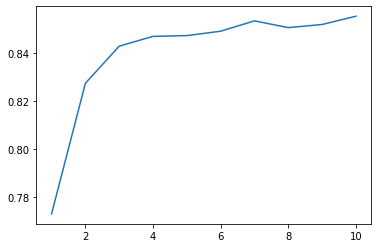

In [ ]:
plt.plot(range(1,11),scores_list)

In [ ]:
def get_best_rf(scores_list):
  n=np.argmax(scores_list)
  rf_best=RandomForestClassifier(n_estimators=(5*n)+1)
  rf_best.fit(train_data,Y_train)
  return rf_best


In [ ]:
n=np.argmax(scores_list)
n

9

In [ ]:
rf_best=get_best_rf(scores_list)
Y_hat=rf_best.predict(test_data)
accuracy_rf=sum(Y_hat==Y_test)/len(Y_hat)
f1_rf=f1_score(y_true=Y_test,y_pred=Y_hat,pos_label='g')
precision_rf=precision_score(y_true=Y_test,y_pred=Y_hat,pos_label='g')
recall_rf=recall_score(y_true=Y_test,y_pred=Y_hat,pos_label='g')
print(str(recall_rf)+" "+str(precision_rf)+" "+str(f1_rf)+" "+str(accuracy_rf))
confusion_matrix_rf=confusion_matrix(y_true=Y_test,y_pred=Y_hat)
print(confusion_matrix_rf)

0.8641908376253727 0.9026047565118913 0.8829801966486637 0.8519102698913424
[[3188  501]
 [ 344 1673]]


In [ ]:
scores_list=[]
for i in range(1,50,5):
  ada=AdaBoostClassifier(n_estimators=i)
  ada.fit(train_data,Y_train)
  scores=cross_val_score(rf,train_data,Y_train,cv=5)
  average_score=sum(scores)/len(scores)
  scores_list.append(average_score)

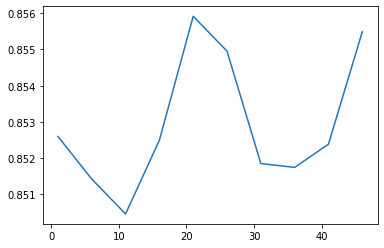

In [ ]:
plt.plot(range(1,50,5),scores_list)

In [ ]:
def get_best_ada(scores_list):  
  n=np.argmax(scores_list)
  ada_best=RandomForestClassifier(n_estimators=(5*n)+1)
  ada_best.fit(train_data,Y_train)
  return ada_best


In [ ]:
ada_best=get_best_ada(scores_list)
Y_hat=ada_best.predict(test_data)
accuracy_ada=sum(Y_hat==Y_test)/len(Y_hat)
f1_ada=f1_score(y_true=Y_test,y_pred=Y_hat,pos_label='g')
precision_ada=precision_score(y_true=Y_test,y_pred=Y_hat,pos_label='g')
recall_ada=recall_score(y_true=Y_test,y_pred=Y_hat,pos_label='g')
print(str(recall_ada)+" "+str(precision_ada)+" "+str(f1_ada)+" "+str(accuracy_ada))
confusion_matrix_ada=confusion_matrix(y_true=Y_test,y_pred=Y_hat)
print(confusion_matrix_ada)

0.8712388181078883 0.9028089887640449 0.8867429990343495 0.8561163687346652
[[3214  475]
 [ 346 1671]]


In [ ]:
accuracies={"Decision Tree":accuracy_dt,"AdaBoost":accuracy_ada_best,"KNN":accuracy_knn,"Random Forest":accuracy_rf,"Naive Bayes":accuracy_nb,"Neural Network":eva[1]}
f1_scores={"Decision Tree":f1_dt,"AdaBoost":f1_ada,"KNN":f1_knn,"Random Forest":f1_rf,"Naive Bayes":f1_nb,"Neural_Network":f1_nn}
precision_scores={"Decision Tree":precision_dt,"AdaBoost":precision_ada,"KNN":precision_knn,"Random Forest":precision_rf,"Naive Bayes":precision_nb,"Neural Network"}
recall_scores={"Decision Tree":recall_dt,"AdaBoost":recall_ada,"KNN":recall_knn,"Random Forest":recall_rf,"Naive Bayes":recall_nb}


<BarContainer object of 5 artists>

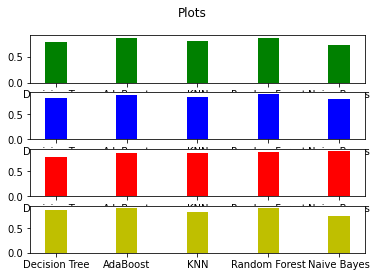

In [ ]:
fig, axs = plt.subplots(4)
fig.suptitle('Plots')
axs[0].bar(accuracies.keys(), accuracies.values(), width=0.3, color='g')
axs[1].bar(f1_scores.keys(), f1_scores.values(), width=0.3, color='b')
axs[2].bar(recall_scores.keys(), recall_scores.values(), width=0.3, color='r')
axs[3].bar(precision_scores.keys(), precision_scores.values(), width=0.3, color='y')

In [ ]:
normalizer=Normalization()
#train_asnp=train_data.values
normalizer.adapt(train_asnp)
model=Sequential([normalizer,
                  Dense(8,'relu'),
                  Dense(8,'relu'),
                  Dense(1,'sigmoid')
                  ])
optimizer=Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
model.fit(train_asnp,Y_asnp,epochs=100,validation_split=0.2,batch_size=1)

Epoch 1/100
7473/7473 [==============================] - 9s 1ms/step - loss: 0.7041 - accuracy: 0.6039 - val_loss: 0.8062 - val_accuracy: 0.2606
Epoch 2/100
7473/7473 [==============================] - 8s 1ms/step - loss: 0.5376 - accuracy: 0.7338 - val_loss: 0.7405 - val_accuracy: 0.4805
Epoch 3/100
7473/7473 [==============================] - 8s 1ms/step - loss: 0.4690 - accuracy: 0.7733 - val_loss: 0.6704 - val_accuracy: 0.6009
Epoch 4/100
7473/7473 [==============================] - 8s 1ms/step - loss: 0.4357 - accuracy: 0.7989 - val_loss: 0.6340 - val_accuracy: 0.6319
Epoch 5/100
7473/7473 [==============================] - 8s 1ms/step - loss: 0.4195 - accuracy: 0.8071 - val_loss: 0.6366 - val_accuracy: 0.6303
Epoch 6/100
7473/7473 [==============================] - 8s 1ms/step - loss: 0.4064 - accuracy: 0.8093 - val_loss: 0.6145 - val_accuracy: 0.6447
Epoch 7/100
7473/7473 [==============================] - 9s 1ms/step - loss: 0.4036 - accuracy: 0.8118 - val_loss: 0.5932 - val_ac

KeyboardInterrupt: ignored

In [ ]:
train_asnp=train_data.values

In [ ]:
Y_asnp=Y_train.values

In [ ]:
Y_asnp=Y_asnp=='g'

In [ ]:
Y_asnp=Y_asnp.reshape(9342,1)
Y_asnp.shape

(9342, 1)

In [ ]:
train_asnp=np.array(train_asnp)

In [ ]:
train_asnp.shape

(9342, 10)

In [ ]:
train_data=train_data.astype(np.float32)

In [ ]:
test_data=test_data.astype(np.float32)
test_asnp=test_data.values
Y_asnp_test=Y_test=='g'

In [ ]:
eva=model.evaluate(test_asnp,Y_asnp_test,batch_size=1)
y_pred=model.predict(test_asnp)


5706/5706 [==============================] - 7s 1ms/step - loss: 0.3427 - accuracy: 0.8587


In [ ]:
accuracies["Neural Network"]=eva[1]

NameError: ignored

<BarContainer object of 6 artists>

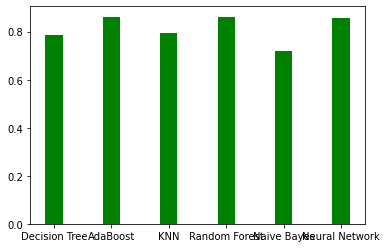

In [ ]:
plt.bar(accuracies.keys(), accuracies.values(), width=0.3, color='g')


In [ ]:
#Y_hat=model.predict(test_asnp)
f1_nn=f1_score(y_true=Y_asnp_test,y_pred=y_pred,pos_label=True)
precision_nn=precision_score(y_true=Y_asnp_test,y_pred=y_pred,pos_label=True)
recall_nn=recall_score(y_true=Y_asnp_test,y_pred=y_pred,pos_label=True)
print(str(recall_nn)+" "+str(precision_nn)+" "+str(f1_nn)+" "+str(eva[1]))
confusion_matrix_nn=confusion_matrix(y_true=Y_asnp_test,y_pred=y_pred)
print(confusion_matrix_nn)

0.9289780428300353 0.8630067992948879 0.8947780678851174 0.8587451577186584
[[1473  544]
 [ 262 3427]]


In [ ]:
Y_hat=Y_hat>0.5

In [ ]:
Y_test_nn=Y_test=='g'

NameError: ignored

In [ ]:
y_pred=y_pred>0.5

In [ ]:
Y_asnp_test

18152    False
2571      True
12202     True
4508      True
14903    False
         ...  
6353      True
6974      True
7532      True
15335    False
6711      True
Name: class, Length: 5706, dtype: bool

In [ ]:
Y_asnp_test=Y_asnp_test.to_list()

In [ ]:
Y_asnp_test

18152    False
2571      True
12202     True
4508      True
14903    False
         ...  
6353      True
6974      True
7532      True
15335    False
6711      True
Name: class, Length: 5706, dtype: bool

In [ ]:
Y_asnp

array([ True,  True,  True, ..., False, False, False])

In [ ]:
Y_asnp_test=Y_asnp_test.to_list()

In [ ]:
y_pred

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [False],
       [False]])

In [ ]:
Y_asnp_test=Y_asnp_test.to_list()